# Lane Detection Using OpenCV

The purpose of this notebook is to explore common `OpenCV` functions and dig into the fundamentals of lane detection.

## Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from functions import *
%matplotlib inline

## Read Image

Read in an image showing an example of highway driving. From the image below we can see that the right line is solid and the left line is dashed with reflective markers in-between the dashes. The scenario we are examining is an ideal situation. The lines are clear and easy to read, there are no other markings or objects on the road ahead of us, and the road is straight. Thought such a case is simple, it provides a good foundation to understand lane detection.

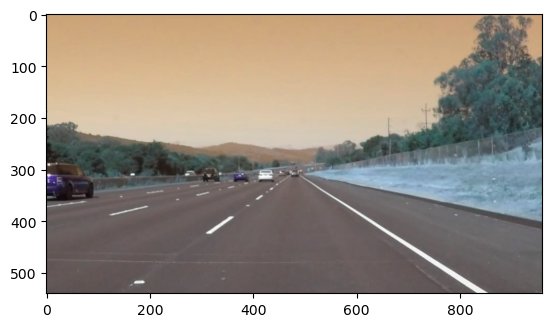

In [2]:
img = cv2.imread('test_images/solidWhiteRight.jpg')
plt.imshow(img)

## Transformations

### Canny Edge Detection

The first step in the lane detection problem is to identify the edges, or boundries, of the features in our image. Specifically, we want to see if we can find the edges of the lines on the road. Canny edge detection is a fundamental method of edge detection that is based on the idea of calculating the gradient between subsequent pixel intensities.

First we can convert the image to multi-channel into single-channel by applying a grayscale transformation as we want to focus on the average intensity instead of a color-specific intensity of a pixel.

Next a Gaussian filter is applied to reduce the noise in the image and make the gradient calculation less susceptible to noise.

A **Sobel kernal** is then applied vertically and horizontally to calculate the first derivatives. The resulting two derived images allow us to apply the edge gradient calculation.

The image is then scanned to find the local neighbourhood maximum in the vertical and horizontal directions. All pixels aside from the pixels associated with the local maxima are then dropped, leaving an image with a black background and white lines corresponding to the edges.

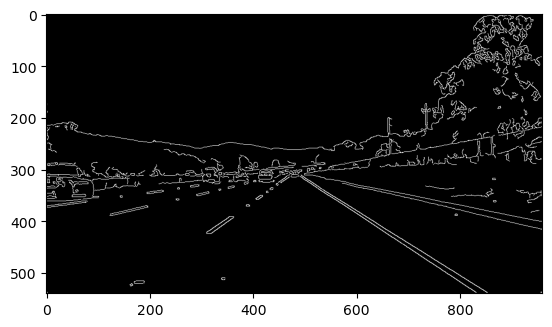

In [3]:
canny_img = canny(np.copy(img), low_thresh=25, upper_thresh=100)
plt.imshow(canny_img, cmap='gray')

### Region of Interest

In the final product, we do not want to display the edges of every single object/feature in our image, we only want to focus on the lines on the road ahead of us. To help achieve this, the image can be masked such that only the road ahead is considered for lane detection and all other aspects of the image are ignored. The image below shows the selected region of interest.

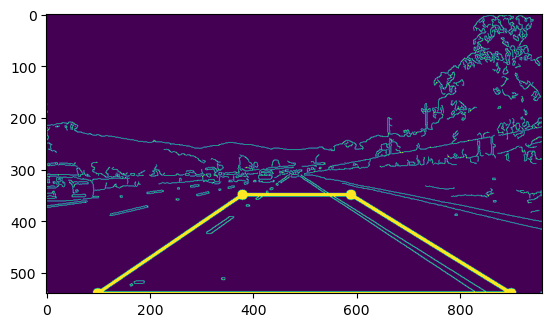

In [4]:
height = canny_img.shape[0]
roi_points = np.array([[
    (100, height), (380, 350), (590, 350), (900, height)
]])

canny_points = draw_roi(np.copy(canny_img), roi_points, (255, 0, 0))
plt.imshow(canny_points)

The image below shows the output of the masked image. This is what we will use to detect the lines going forward.

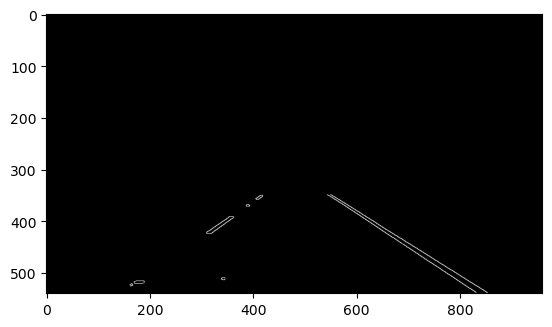

In [5]:
roi_canny_img = roi(canny_img, roi_points)
plt.imshow(roi_canny_img, cmap='gray')

### Hough Lines

Great, so now we have the edges of the lane markers on the road only for the lane the vehicle is in. However, the edges alone cannot describe the idea of _lanes_. Lanes can be seperated by solid lines, dashed lines, etc. So far we just know where the edges of theses lines are, what we want to do is draw a line over these edges to describe the left and right lane boundries.

The edges in the previous images are collection of white pixels (points) that don't have any relation to one another. While we can obviously see that they are lines, computers do not. So we need to find a method that can define lines out of these pixels and the **Hough Transforms** is the method that will help us accomplish this.

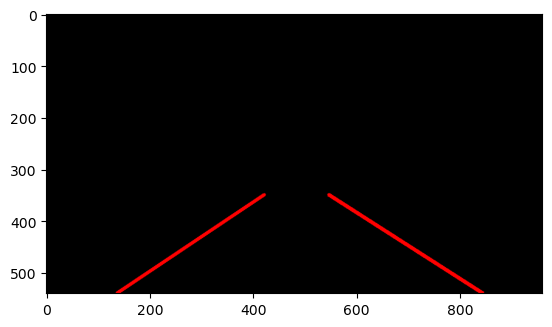

In [7]:
hough_img = hough_lines(roi_canny_img, 2, np.pi/180, 50, 10, 5, roi_points)
plt.imshow(hough_img)

### Weighted Addition

Great! We've got a line representation of the left and right lane markers. Now all we need to do is layer this image on top of the original image. There is a reason why the background of the previous image is black. As we know, a black pixel is represented with a intensity of zero, which as a 8-bit binary values is represented as `0b00000000`. We also know that majority (if not all) of the pixels in our original image will be non-zero. The binary value might be `0b00010010`, `0b01110110`, `0b00000001`, etc. If we perform a bitwise `AND` operation between a black pixel and a non-black pixel, the result will the value of the non-black pixel. 

If we know that the `AND` truth table as such:

| **A** | **B** | **Y** |
|-------|-------|-------|
| 0     | 0     | **0** |
| 0     | 1     | **0** |
| 1     | 0     | **0** |
| 1     | 1     | **1** |

If we perform a bitwise `AND` operation between a non-black pixel (`11010011`) and a black pixel (`0000000`), the result will be as follows:

![Binary Addition](https://latex.codecogs.com/svg.latex?%5Cbegin%7Barray%7D%7Br%7D%0A%2011010011_2%20%5C%5C%0A%20%5C%26%5C%2600000000_2%20%5C%5C%0A%20%5Chline%20%5C%5C%0A%2011010011_2%20%5C%5C%0A%5Cend%7Barray%7D)

We can see that the result is the value of the non-black pixel. In this case, the `cv2.`




In [ ]:
lane_img = np.copy(img)
# weighted_img = weighted_image(lane_img, hough_img, 0.8, 1.0, 0)

test = cv2.addWeighted(lane_img, 0.8, hough_img, 1.0, 0)
plt.imshow(test)

### Averaging Lines

In [ ]:
lane_img = np.copy(img)
hough_img = hough_lines(roi_canny_img, 2, np.pi/180, 50, 10, 5, points)

test = cv2.addWeighted(lane_img, 0.8, hough_img, 1.0, 0)
plt.imshow(test)

## Pipeline

Read in image

In [ ]:
img = cv2.imread('problem_frame.png')
plt.imshow(img)

Define region of interest points

In [ ]:
img_height = img.shape[0]

points = np.array([[
    (150, img_height), (400, 350), (600, 350), (900, img_height)
]])

Run pipeline

In [ ]:
result = pipeline(img, points)
plt.imshow(result)

## Video

In [ ]:
cap = cv2.VideoCapture('test_videos/solidWhiteRight.mp4')
i = 1
while(cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting...")
        break
    # print(i)
    result = pipeline(frame, points)
    cv2.imshow('Result', result)
    cv2.waitKey(1)
    i+=1
    
    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
plt.imshow(frame)
# plt.imsave('problem_frame.png', frame)